In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from collections import defaultdict
import numpy as np
import pandas as pd
import crocoddyl
crocoddyl.switchToNumpyArray()
%matplotlib inline

In [3]:






def point(h, k, r):
    theta = random.random() * 2 * np.pi
    return h + np.cos(theta) * r, k + np.sin(theta) * r



def generate_trajectories_train(ntraj:int = 1):

    trajectory = []
    
    for _ in range(ntraj):
        initial_config = [random.uniform(-1.99, 1.99), random.uniform(-1.99, 1.99), 0]            
        model = crocoddyl.ActionModelUnicycle()

        model.costWeights = np.matrix([1, 0.3]).T

        problem = crocoddyl.ShootingProblem(np.matrix(initial_config).T, [ model ] * 30, model)
        ddp = crocoddyl.SolverFDDP(problem)
        ddp.solve([], [], 1000)
        if ddp.iter < 1000:

            # Store trajectory(ie x, y) 
            a = np.delete(np.array(ddp.xs), 2, 1)
            a = np.array(a.flatten())
            b = np.append(a, sum(d.cost for d in ddp.datas()))
            trajectory.append(b)
            #trajectory.append(sum(d.cost for d in ddp.datas()))


    # Dataset 2: Shape (number of init_points, 62)..columns are recurring (x,y). 
    # The first two columns will form train.
    # The last column is the cost associated with each trajectory
    trajectory = np.array(trajectory)
    print(trajectory.shape)
    df_trajectory = pd.DataFrame(trajectory[0:,0:])
    

    return df_trajectory

def generate_trajectories_test(ntraj: int = 50):
    trajectory = []
    
    for _ in range(ntraj):
        x, y = point(0, 0, 2.1)    
        initial_config = [x, y, 0]              
        model = crocoddyl.ActionModelUnicycle()

        model.costWeights = np.matrix([1, 0.3]).T

        problem = crocoddyl.ShootingProblem(np.matrix(initial_config).T, [ model ] * 30, model)
        ddp = crocoddyl.SolverFDDP(problem)
        ddp.solve([], [], 1000)
        if ddp.iter < 1000:

            # Store trajectory(ie x, y) 
            a = np.delete(np.array(ddp.xs), 2, 1)
            a = np.array(a.flatten())
            b = np.append(a, sum(d.cost for d in ddp.datas()))
            trajectory.append(b)
            #trajectory.append(sum(d.cost for d in ddp.datas()))


    # Dataset 2: Shape (number of init_points, 62)..columns are recurring (x,y). 
    # The first two columns will form train.
    # The last column is the cost associated with each trajectory
    trajectory = np.array(trajectory)
    print(trajectory.shape)
    df_trajectory = pd.DataFrame(trajectory[0:,0:])
    

    return df_trajectory


T = [100]
R = [2.1]



def rtpairs(r, n):

    for i in range(len(r)):
       for j in range(n[i]):    
        yield r[i], j*(2 * np.pi / n[i])


def trajectories_test():
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style("whitegrid")
    mpl.rcParams['figure.dpi'] = 80
    
    cost_trajectory = defaultdict()
    trajectory = []

    for r, t in rtpairs(R, T):
        x = r * np.cos(t) 
        y = r * np.sin(t)
        initial_config = [x, y, 0]              
        model = crocoddyl.ActionModelUnicycle()

        model.costWeights = np.matrix([1, 0.3]).T

        problem = crocoddyl.ShootingProblem(np.matrix(initial_config).T, [ model ] * 30, model)
        ddp = crocoddyl.SolverFDDP(problem)
        ddp.solve([], [], 1000)
        if ddp.iter < 1000:
            # Store trajectory(ie x, y) 
            a = np.delete(np.array(ddp.xs), 2, 1)
            # to plot
            cost_trajectory[sum(d.cost for d in ddp.datas())] = a

            a = np.array(a.flatten())
            b = np.append(a, sum(d.cost for d in ddp.datas()))
            trajectory.append(b)
            #trajectory.append(sum(d.cost for d in ddp.datas()))
            
   # Dataset 2: Shape (number of init_points, 62)..columns are recurring (x,y). 
    # The first two columns will form train.
    # The last column is the cost associated with each trajectory
    trajectory = np.array(trajectory)
    print(trajectory.shape)
    df_trajectory = pd.DataFrame(trajectory[0:,0:])
    
    
    
    c = cost_trajectory.keys()
    norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.viridis)
    cmap.set_array([])

    fig = plt.figure(figsize=(12, 10))

    for key, trajectory in cost_trajectory.items():
        plt.scatter(trajectory[:, 0], trajectory[:, 1], marker = '', zorder=2, s=50,linewidths=0.2,alpha=.8, cmap = cmap )
        plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))
        #label = np.around(key, 2)
        #plt.annotate(label, xy = (trajectory[0,0], trajectory[0,1]),
        #                arrowprops=dict(arrowstyle="->",
        #                        connectionstyle="angle3,angleA=0,angleB=-90"),
        #                horizontalalignment='left',
        #                verticalalignment='bottom',)

    plt.xlabel("X Coordinates", fontsize = 20)
    plt.ylabel("Y Coordinates", fontsize = 20)
    plt.title("Trajectories from Crocoddyl (Not Learned)", fontsize =20)

    plt.colorbar(cmap)
    

    return df_trajectory
         

(10000, 63)
(100, 63)


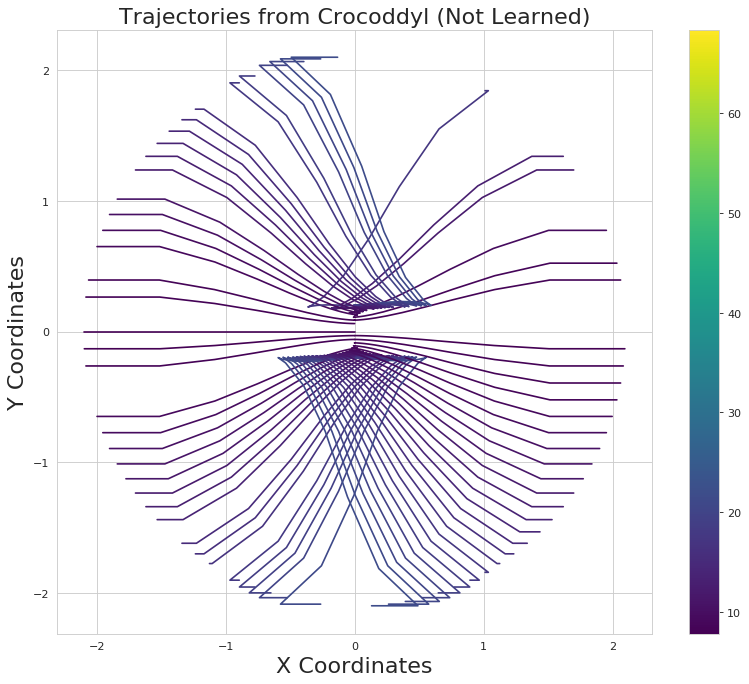

In [4]:
df_train = generate_trajectories_train(10000)
df_test = trajectories_test()

train_dataset = df_train.values
test_dataset = df_test.values

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
# Preprocessing control_dataset


trajectory_scaler = MinMaxScaler()
train_dataset = trajectory_scaler.fit_transform(train_dataset)
print(train_dataset.shape)

test_dataset = trajectory_scaler.fit_transform(test_dataset)
print(test_dataset.shape)


(10000, 63)
(100, 63)


In [6]:
x_train, y_train = train_dataset[0:, 0:2], train_dataset[0:,2:]
x_test, y_test = test_dataset[0:, 0:2], test_dataset[0:,2:]
print("TRAIN ",x_train.shape,",", y_train.shape)
print("TEST ", x_test.shape,",", y_test.shape)


TRAIN  (10000, 2) , (10000, 61)
TEST  (100, 2) , (100, 61)


In [7]:
from keras import backend as K 
K.clear_session()
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

    
N_HIDDEN = 1
lr = 1e-3
rho = 0.9
    
    
model = Sequential()
model.add(Dense(128, input_dim=(x_train.shape[1])))
model.add(Dense(64,
                activation = "relu",
                )) 
#for _ in range(N_HIDDEN):
    #model.add(Dense(256, activation = "tanh"))

model.add(Dense(128,
                activation = "tanh",
                )) 
model.add(Dense(y_train.shape[1], 
                activation = 'linear'))        

sgd = optimizers.SGD(lr=lr, clipnorm=1.)

adam = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)


model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['mean_squared_error', "mean_absolute_error"])

model.fit(x_train, 
          y_train,
          epochs = 150,
          batch_size= 64,
          verbose = 2
         )

# evaluate the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]))



# serialize model to JSON
#model_json = model.to_json()
#with open("trajectory.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("trajectory.h5")
#print("Saved model to disk")

Using TensorFlow backend.


Epoch 1/150
 - 1s - loss: 0.0503 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1602
Epoch 2/150
 - 0s - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0995
Epoch 3/150
 - 0s - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0731
Epoch 4/150
 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0519
Epoch 5/150
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0419
Epoch 6/150
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0384
Epoch 7/150
 - 0s - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0329
Epoch 8/150
 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0303
Epoch 9/150
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0295
Epoch 10/150
 - 0s - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0295
Epoch 11/150
 - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_

Epoch 90/150
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0166
Epoch 91/150
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0171
Epoch 92/150
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0171
Epoch 93/150
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0162
Epoch 94/150
 - 0s - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0171
Epoch 95/150
 - 0s - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0175
Epoch 96/150
 - 0s - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0174
Epoch 97/150
 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0160
Epoch 98/150
 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0164
Epoch 99/150
 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0199
Epoch 100/150
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean

In [8]:
predictions = model.predict_on_batch(x_test)
results_ = np.hstack((x_test, predictions))
results = trajectory_scaler.inverse_transform(results_)

In [9]:
from collections import defaultdict

cost_trajectory = defaultdict()

for i in results:
    i = i.tolist()
    key = i.pop(-1)
    items = np.array(i).reshape(31, 2)
    cost_trajectory[key] = items


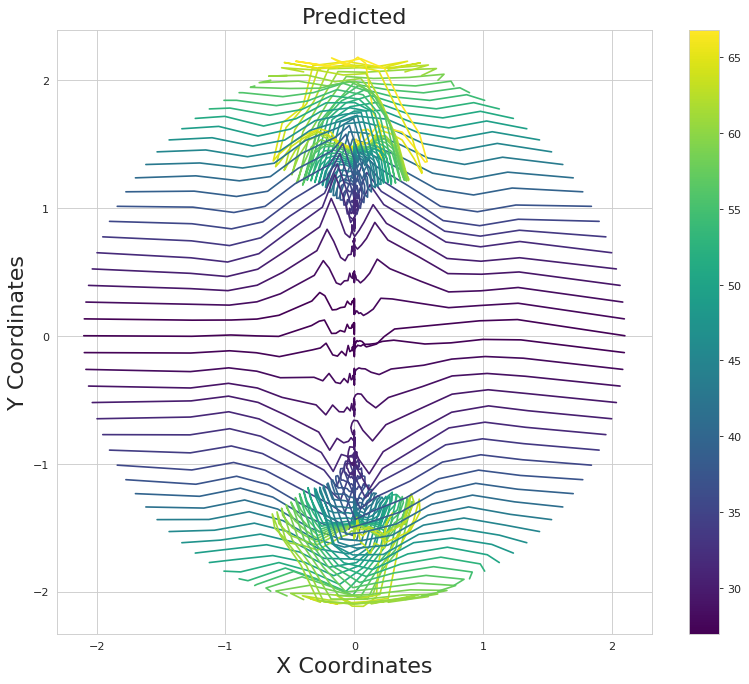

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 80

c = cost_trajectory.keys()
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))
cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.viridis)
cmap.set_array([])

fig = plt.figure(figsize=(12, 10))

for key, trajectory in cost_trajectory.items():
    plt.scatter(trajectory[:, 0], trajectory[:, 1], marker = '',
                zorder=2, s=50,linewidths=0.2,alpha=.8, cmap = cmap )
    plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))
    #label = np.around(key, 2)
    #plt.annotate(label, xy = (trajectory[0,0], trajectory[0,1]),
    #                arrowprops=dict(arrowstyle="->",
    #                        connectionstyle="angle3,angleA=0,angleB=-90"),
    #                horizontalalignment='left',
    #                verticalalignment='bottom',)

plt.xlabel("X Coordinates", fontsize = 20)
plt.ylabel("Y Coordinates", fontsize = 20)
plt.title("Predicted", fontsize =20)

plt.colorbar(cmap)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 61)                7869      
Total params: 24,829
Trainable params: 24,829
Non-trainable params: 0
_________________________________________________________________
